In [43]:
import torch
import torch.nn as nn

import numpy as np
import pandas as pd

from src.data.datasets import ModelParamsDataset

from src.data.helpers import get_moons_dataset, rotate, get_accuracy
from src.model.models import DBModel, TSModel, SModel

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from src.visualization.visualize import plot_interpolation, plot_decision_boundary

from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

In [44]:
# Hyperparameters
epochs = 100
kdl_weight = 1
batch_size = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random_seed = 0
latent_dim = 2
dropout = 0.0

torch.manual_seed(random_seed)

# Model
autoencoder = TSModel(latent_dim, dropout)
teacher = DBModel()
teacher.requires_grad_(False)
student = SModel()
student.requires_grad_(False)

autoencoder.to(device)
teacher.to(device)
student.to(device)

# Optimizer
optimizer = torch.optim.Adam(autoencoder.parameters(), lr=1e-3)
loss_fn = nn.BCELoss()

# Dataset
dataset = ModelParamsDataset("../../data/eight_angles_small.csv")
train_indices, test_indices, _, _ = train_test_split(range(len(dataset)), dataset.angles, stratify=dataset.angles, test_size=0.2, random_state=random_seed)
train_dataset = Subset(dataset, train_indices)
test_dataset = Subset(dataset, test_indices)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Grid of points 100x100
xx, yy = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))
input = np.c_[xx.ravel(), yy.ravel()]
input = torch.tensor(input, dtype=torch.float32)
input = input.unsqueeze(0).repeat(batch_size, 1, 1)
input = input.to(device)

# Locations
path = "../../models/autoencoders/teacher_student"
model_path = "{}/model_final.pth".format(path)

## Train

In [4]:
autoencoder.train()
for epoch in tqdm(range(epochs)):
    total_loss = 0
    for (parameters_batch, angles_batch) in train_dataloader:
        # Model prediction
        parameters_batch = parameters_batch.to(device)
        reconstructed = autoencoder(parameters_batch)
        output = student(reconstructed, input)

        # Ground truth
        goal = teacher(parameters_batch, input)

        optimizer.zero_grad()
        loss = loss_fn(output, goal)
        total_loss += loss.item()
        loss.backward()
        optimizer.step()
        
    print(f"Epoch {epoch} - Loss: {total_loss}")
    if(epoch % 5 == 0):
        torch.save(autoencoder.state_dict(), f"{path}/checkpoint_{epoch}.pth")

torch.save(autoencoder.state_dict(), model_path)

  0%|          | 0/100 [00:00<?, ?it/s]

Epoch 0 - Loss: 317.7497479915619
Epoch 1 - Loss: 203.90903347730637
Epoch 2 - Loss: 152.75942288339138
Epoch 3 - Loss: 137.1597354710102
Epoch 4 - Loss: 123.28511250019073
Epoch 5 - Loss: 116.31455919146538
Epoch 6 - Loss: 108.9417023062706
Epoch 7 - Loss: 103.7635762989521
Epoch 8 - Loss: 111.33776040375233
Epoch 9 - Loss: 124.82467211782932
Epoch 10 - Loss: 107.20476926863194
Epoch 11 - Loss: 109.02406719326973
Epoch 12 - Loss: 103.72147244215012
Epoch 13 - Loss: 97.67756874859333
Epoch 14 - Loss: 93.26141583919525
Epoch 15 - Loss: 91.20111779868603
Epoch 16 - Loss: 93.38316433131695
Epoch 17 - Loss: 91.39970043301582
Epoch 18 - Loss: 93.99814711511135
Epoch 19 - Loss: 89.39595893025398
Epoch 20 - Loss: 90.41920319199562
Epoch 21 - Loss: 90.13388693332672
Epoch 22 - Loss: 88.15194889903069
Epoch 23 - Loss: 90.1631072089076
Epoch 24 - Loss: 89.61426754295826
Epoch 25 - Loss: 112.98515874147415
Epoch 26 - Loss: 100.29352283477783
Epoch 27 - Loss: 89.55368167161942
Epoch 28 - Loss: 87.

In [47]:
def plot_decision_boundary(parameters, model, X, y, steps=1000, color_map='Paired', axis=True, title=None, path="../../reports/fig.pdf"):
    '''
    Plot the decision boundary of a model.

    Parameters:
        X (np.array): The dataset.
        y (np.array): The labels.
        steps (int): The number of steps to take in the meshgrid.
        color_map (str): The color map to use.
        device (str): The device to use.
    '''
    x_min = X[:, 0].min() - 1
    x_max = X[:, 0].max() + 1
    y_min = X[:, 1].min() - 1
    y_max = X[:, 1].max() + 1

    xx, yy = np.meshgrid(np.linspace(x_min, x_max, steps), np.linspace(y_min, y_max, steps))
    X_grid = np.c_[xx.ravel(), yy.ravel()]
    X_grid = torch.from_numpy(X_grid).float()

    y_boundary = model(parameters, X_grid).detach().numpy().round()
    y_boundary = np.array(y_boundary).reshape(xx.shape)

    color_map = plt.get_cmap(color_map)
    plt.contourf(xx, yy, y_boundary, cmap=color_map, alpha=0.5)
    plt.xlim(x_min, x_max)
    plt.ylim(y_min, y_max)

    class_1 = [X[y==0,0], X[y==0,1]]
    class_2 = [X[y==1,0], X[y==1,1]]
    plt.scatter(class_1[0], class_1[1], color=color_map.colors[1], marker='o')
    plt.scatter(class_2[0], class_2[1], color=color_map.colors[11], marker='x')

    # plt.legend(["0","1"])

    if title:
        plt.title(title)
    
    if not axis:
        plt.xticks([])
        plt.yticks([])

    plt.savefig(path)
    plt.show()
    plt.close()

In [48]:
plt.rcParams.update({'font.size': 24})

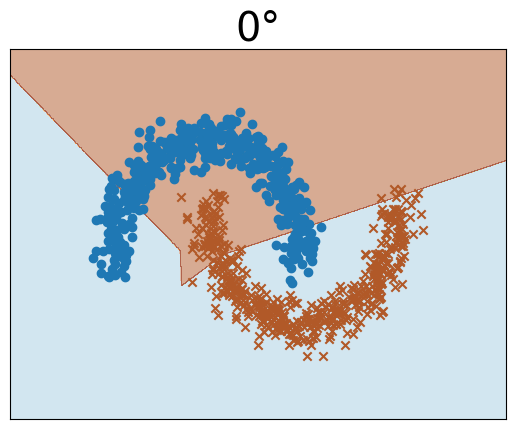

In [52]:
autoencoder = TSModel(latent_dim, dropout)
smodel = SModel(False)
tmodel = DBModel(False)
autoencoder.load_state_dict(torch.load(model_path))
autoencoder.eval()

index = 6650
parameters = dataset[index][0].unsqueeze(0)
angle = dataset[index][1]
reconstructed = autoencoder(parameters)
X, y = get_moons_dataset()
plot_decision_boundary(reconstructed.squeeze(), smodel, X, y, axis=False, title=f"{angle}°", path="../../reports/compress-bad-case-reconstructed.pdf")

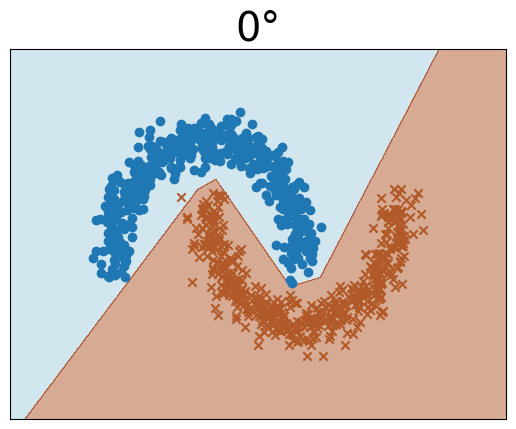

In [35]:
plot_decision_boundary(reconstructed.squeeze(), smodel, X, y, axis=False, title=f"{angle}°")

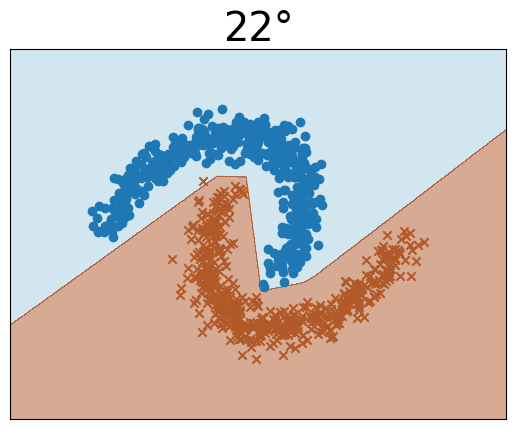

In [40]:
autoencoder = TSModel(latent_dim, dropout)
autoencoder.load_state_dict(torch.load(model_path))
autoencoder.eval()
smodel = SModel(False)
tmodel = DBModel(False)

dataset = ModelParamsDataset("../../data/extra_angles.csv")

index = 6650
parameters = dataset[index][0].unsqueeze(0)
angle = dataset[index][1]
reconstructed = autoencoder(parameters)
X, y = get_moons_dataset()
X_rotated = rotate(X, angle)
plot_decision_boundary(parameters.squeeze(), tmodel, X_rotated, y, axis=False, title=f"{angle}°")

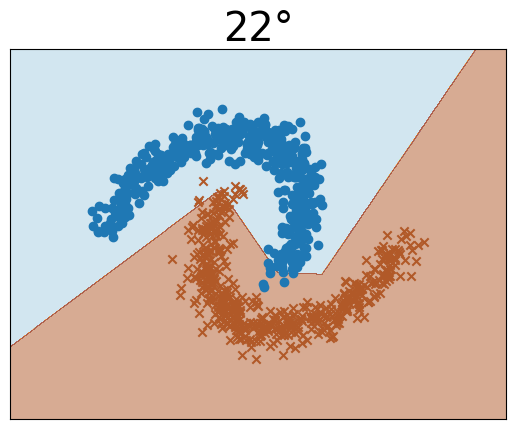

In [42]:
plot_decision_boundary(reconstructed.squeeze(), smodel, X_rotated, y, axis=False, title=f"{angle}°")


## Latent space

(80000, 2)
(80000, 2)


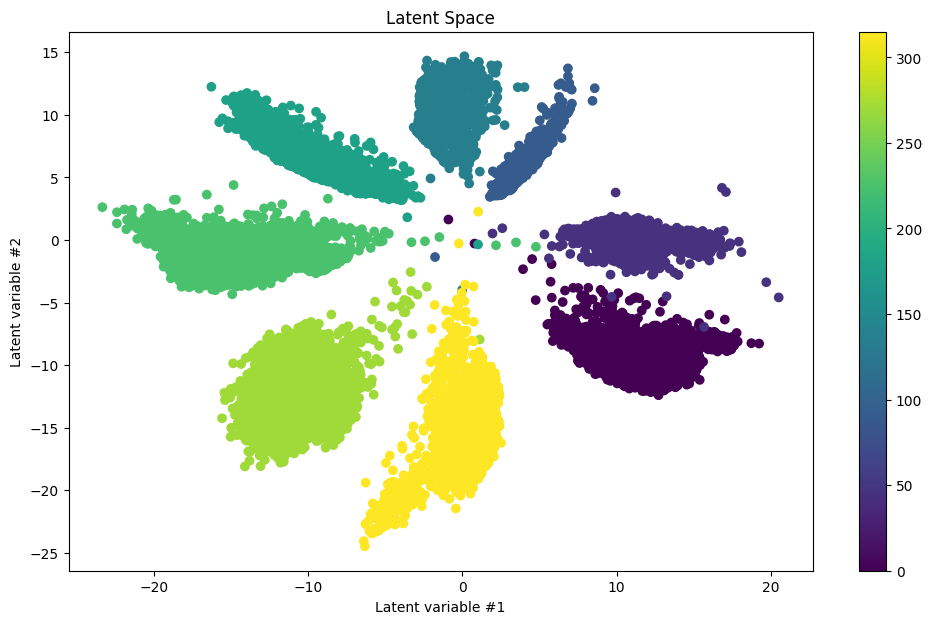

In [13]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd

autoencoder = TSModel(latent_dim, dropout)
autoencoder.load_state_dict(torch.load(model_path))
autoencoder.eval()

raw = pd.read_csv("../data/eight_angles_small.csv")
weights = raw.drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
angles = raw["angle"].to_numpy()

weights = torch.tensor(weights).float()
latent = autoencoder.encoder(weights).detach().numpy()
print(latent.shape)

# new_raw = pd.read_csv("../data/extra_angles.csv")
# new_weights = new_raw.drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
# new_angles = new_raw["angle"].to_numpy()

# new_weights = torch.tensor(new_weights).float()
# new_latent = autoencoder.encoder(new_weights).detach().numpy()

# latent = np.concatenate((latent, new_latent), axis=0)
# angles = np.concatenate((angles, new_angles), axis=0)

X_pca = latent
print(X_pca.shape)
fig = plt.figure(figsize=(12,7))
ax = fig.add_subplot()
img = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=angles, cmap="viridis")
fig.colorbar(img)

ax.set_xlabel('X')
ax.set_ylabel('Y')
# ax.set_zlabel('Z')

# ax.view_init(0, 0, 90)

plt.title("Latent Space")
plt.xlabel("Latent variable #1")
plt.ylabel("Latent variable #2")
plt.show()

## Reconstructed weigths distribution

3945
6650


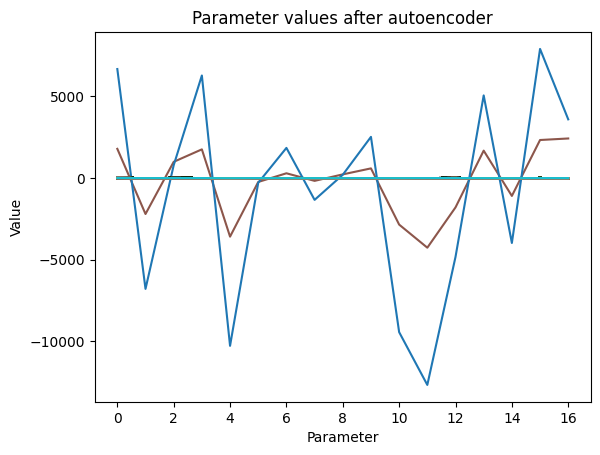

In [16]:
from matplotlib import pyplot as plt

autoencoder = TSModel(latent_dim, dropout)
autoencoder.load_state_dict(torch.load(model_path))
autoencoder.eval()

reconstruction = []
for i in range(8000):
    parameters = dataset[i][0].unsqueeze(0)
    r = autoencoder(parameters)
    r = r.squeeze().detach().numpy()
    reconstruction.append(r)
    if(r.max() > 1000):
        print(i)


for r in reconstruction:
    plt.plot(r)

plt.xlabel("Parameter")
plt.ylabel("Value")
plt.title("Parameter values after autoencoder")
plt.show()

## Accuracy distribution

In [53]:
def get_accuracy1(parameters, X, y):
    '''
    Get the accuracy of a Moons classifier on a moons dataset.
    '''
    model = DBModel(False)
    y_pred = model(parameters, X).squeeze().detach().round().numpy()
    correct = (y_pred == y).sum()
    accuracy = correct / len(y) * 100
    return accuracy

def get_accuracy2(parameters, X, y):
    '''
    Get the accuracy of a Moons classifier on a moons dataset.
    '''
    model = SModel(False)
    y_pred = model(parameters, X).squeeze().detach().round().numpy()
    correct = (y_pred == y).sum()
    accuracy = correct / len(y) * 100
    return accuracy

In [55]:
autoencoder = TSModel(latent_dim, dropout)
autoencoder.load_state_dict(torch.load(model_path))
autoencoder.eval()

dataset = ModelParamsDataset("../../data/eight_angles_small.csv")

trained_accuracies = []
reconstructed_accuracies = []

X, y = get_moons_dataset()

for (parameter, angle) in tqdm(test_dataset):
    X_rotated = rotate(X, angle)
    X_rotated = torch.tensor(X_rotated).float().unsqueeze(0)

    accuracy = get_accuracy1(parameter, X_rotated, y)
    trained_accuracies.append(accuracy)

    reconstructed = autoencoder(parameter.unsqueeze(0))
    reconstructed = reconstructed.squeeze()
    accuracy = get_accuracy2(reconstructed, X_rotated, y)
    reconstructed_accuracies.append(accuracy)

print(f"Mean trained accuracy: {np.mean(trained_accuracies)}")
print(f"Mean reconstructed accuracy: {np.mean(reconstructed_accuracies)}")


  0%|          | 0/16000 [00:00<?, ?it/s]

Mean trained accuracy: 99.8715
Mean reconstructed accuracy: 99.80205000000002


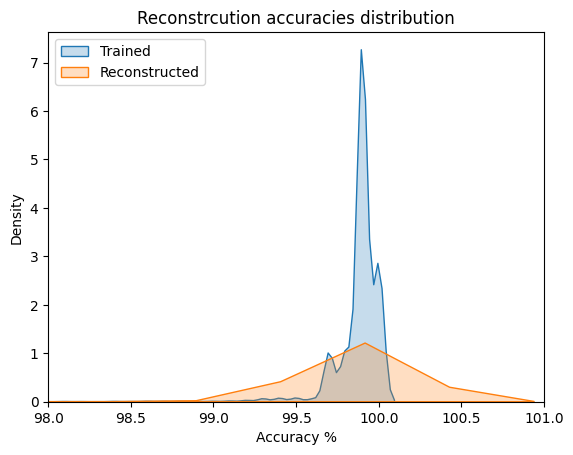

In [30]:

sns.kdeplot(trained_accuracies, fill=True, label="Trained")
sns.kdeplot(reconstructed_accuracies, fill=True, label="Reconstructed")

plt.legend(loc="upper left")
plt.title("Reconstrcution accuracies distribution")
plt.xlabel("Accuracy %")
plt.xlim(98, 101)
plt.show()


  0%|          | 0/20000 [00:00<?, ?it/s]

Mean trained accuracy: 99.88429500000002
Mean reconstructed accuracy: 95.443405


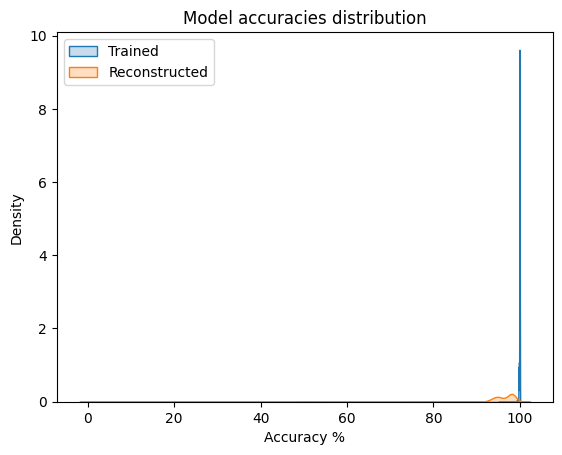

In [18]:
autoencoder = TSModel(latent_dim, dropout)
autoencoder.load_state_dict(torch.load(model_path))
autoencoder.eval()

dataset = ModelParamsDataset("../data/extra_angles.csv")

trained_accuracies = []
reconstructed_accuracies = []

X, y = get_moons_dataset()

for (parameter, angle) in tqdm(dataset):
    X_rotated = rotate(X, angle)
    X_rotated = torch.tensor(X_rotated).float().unsqueeze(0)

    accuracy = get_accuracy1(parameter, X_rotated, y)
    trained_accuracies.append(accuracy)

    reconstructed = autoencoder(parameter.unsqueeze(0))
    reconstructed = reconstructed.squeeze()
    accuracy = get_accuracy2(reconstructed, X_rotated, y)
    reconstructed_accuracies.append(accuracy)

print(f"Mean trained accuracy: {np.mean(trained_accuracies)}")
print(f"Mean reconstructed accuracy: {np.mean(reconstructed_accuracies)}")

sns.kdeplot(trained_accuracies, fill=True, label="Trained")
sns.kdeplot(reconstructed_accuracies, fill=True, label="Reconstructed")

plt.legend(loc="upper left")
plt.title("Model accuracies distribution")
plt.xlabel("Accuracy %")
plt.show()


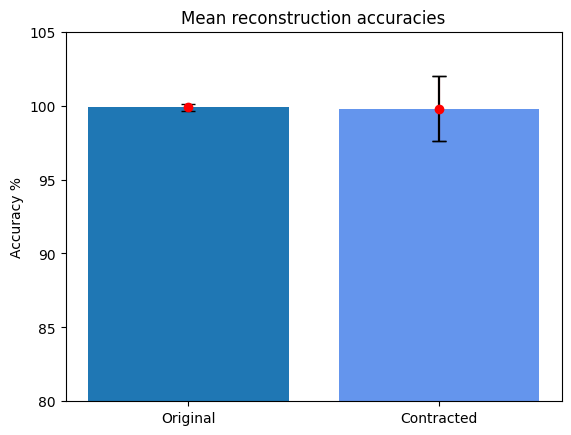

In [37]:
autoencoder_mseloss_mean = np.mean(trained_accuracies)
autoencoder_dbloss_mean = np.mean(reconstructed_accuracies)

autoencoder_mseloss_std = np.std(trained_accuracies)
autoencoder_dbloss_std = np.std(reconstructed_accuracies)


x = np.array(["Original", "Contracted"])
y = np.array([autoencoder_mseloss_mean, autoencoder_dbloss_mean])
e = np.array([autoencoder_mseloss_std, autoencoder_dbloss_std])

plt.errorbar(x, y, e, fmt="o", color="r")

# make these tick labels look good

# make bars thicker
plt.bar(x, y, yerr=e, capsize=5)


# color every second bar green
plt.bar(x[1], y[1], yerr=e[1], capsize=5, color="cornflowerblue")

plt.ylim(80, 105)
plt.title("Mean reconstruction accuracies")
plt.ylabel("Accuracy %")
plt.show()

## Interpolation

  0%|          | 0/7 [00:00<?, ?it/s]

Mean interpolation accuracy: 97.02151428571428


Text(0.5, 0, 'Accuracy %')

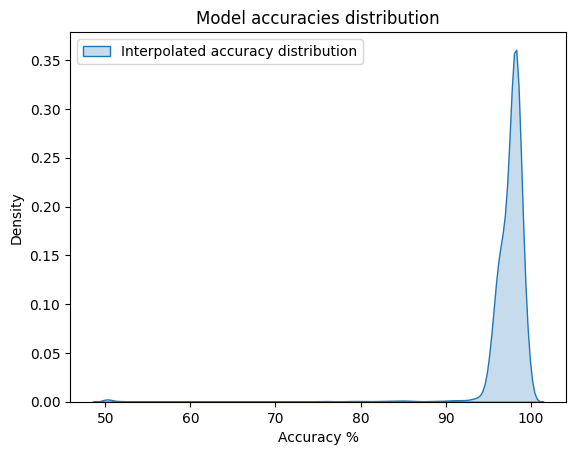

In [12]:
autoencoder = TSModel(latent_dim, dropout)
autoencoder.load_state_dict(torch.load(model_path))
autoencoder.eval()

raw = pd.read_csv("../data/eight_angles_small.csv")
weights_0 = raw.loc[raw["angle"] == 0].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_45 = raw.loc[raw["angle"] == 45].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_90 = raw.loc[raw["angle"] == 90].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_135 = raw.loc[raw["angle"] == 135].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_180 = raw.loc[raw["angle"] == 180].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_225 = raw.loc[raw["angle"] == 225].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_270 = raw.loc[raw["angle"] == 270].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()
weights_315 = raw.loc[raw["angle"] == 315].drop(columns=["model_name", "angle"]).astype('float32').to_numpy()

weights = [weights_0, weights_45, weights_90, weights_135, weights_180, weights_225, weights_270, weights_315]
angles = [0, 45, 90, 135, 180, 225, 270, 315]

X, y = get_moons_dataset()
accuracies = []
for i in tqdm(range(0, 7)):
    for j in range(10000):
        weight_1 = weights[i][j]
        weight_2 = weights[i+1][j]
        angle_1 = angles[i]
        angle_2 = angles[i+1]

        alpha = np.random.uniform(0.4, 0.6)

        latent_1 = autoencoder.encoder(torch.tensor(weight_1).float().unsqueeze(0))
        latent_2 = autoencoder.encoder(torch.tensor(weight_2).float().unsqueeze(0))
        latent = (1-alpha)*latent_1 + alpha*latent_2
        angle = (1-alpha)*angle_1 + alpha*angle_2

        w = autoencoder.decoder(latent).squeeze()
        X_rotated = rotate(X, angle)
        X_rotated = torch.tensor(X_rotated).float()
        accuracy = get_accuracy2(w, X_rotated, y)
        accuracies.append(accuracy)
    
print("Mean interpolation accuracy:", np.mean(accuracies))

sns.kdeplot(accuracies, fill=True, label="Interpolated accuracy distribution")

plt.legend(loc="upper left")
plt.title("Model accuracies distribution")
plt.xlabel("Accuracy %")
# plt.show()

In [17]:
def plot_interpolation(model, datapoint_1, datapoint_2, X, y, alpha):
    parameters_1, angle_1 = datapoint_1
    parameters_2, angle_2 = datapoint_2

    parameters_1 = parameters_1.unsqueeze(0)
    parameters_2 = parameters_2.unsqueeze(0)

    latent_1 = model.encoder(parameters_1)
    latent_2 = model.encoder(parameters_2)

    latent = (1-alpha)*latent_1 + alpha*latent_2
    w = model.decoder(latent).squeeze()

    angle = (1-alpha)*angle_1 + alpha*angle_2
    X_rotated = rotate(X, angle)
    X_rotated = torch.tensor(X_rotated).float()

    plot_decision_boundary(w, X_rotated, y)

In [18]:
autoencoder = TSModel(latent_dim, dropout)
autoencoder.load_state_dict(torch.load(model_path))
autoencoder.eval()

dataset = ModelParamsDataset("../data/eight_angles_small.csv")

X, y = get_moons_dataset()

alpha = 0.8
index_1 = 0
index_2 = 60000

datapoint_1 = dataset[index_1]
datapoint_2 = dataset[index_2]

interact(plot_interpolation, model=fixed(autoencoder), datapoint_1=fixed(datapoint_1), datapoint_2=fixed(datapoint_2), X=fixed(X), y=fixed(y), alpha=widgets.FloatSlider(min=0, max=1, step=0.01, value=0.5))

interactive(children=(FloatSlider(value=0.5, description='alpha', max=1.0, step=0.01), Output()), _dom_classes…

<function __main__.plot_interpolation(model, datapoint_1, datapoint_2, X, y, alpha)>